In [46]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats

from os.path import join

In [3]:
plt.style.use('seaborn')
plt.rc("font", family='Malgun Gothic')
plt.rc('axes', unicode_minus = False)

# 데이터 로드

In [47]:
test = pd.read_csv('data/test.csv')

In [48]:
train = pd.read_csv('data/train.csv')
data = pd.read_csv('data/train.csv')

In [49]:
train.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,income/family,fam_child_diff
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,101250.0,2.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,82500.0,2.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,225000.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,101250.0,2.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,78750.0,2.0


In [7]:
train.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

In [8]:
test.isnull().sum()

index               0
gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

* NA 가 있는 Occpy_type 의 대다수는 Pensioner >> Unemployed // 나머지는 etc?

In [9]:
train[train['occyp_type'].isnull()]['income_type'].value_counts()

Pensioner               4440
Working                 2312
Commercial associate    1026
State servant            392
Student                    1
Name: income_type, dtype: int64

## 함수 모음

In [10]:
def classify_child_type(x) : 
    if x == 0 :
        return 1
    elif x <= 2 : 
        return 2
    else :
        return 3
    
def classify_family(x) : 
    if x <= 2 :
        return x
    elif x <= 4 : 
        return 3
    else :
        return 4

In [11]:
credit_rate = []
credit_col = []

train_columns = ['gender', 'car', 'reality', 'child_num', 'income_type', 'edu_type', 'family_type', 'house_type', 
                 'FLAG_MOBIL', 'work_phone', 'phone', 'email','occyp_type', 'family_size']

def credit_rate(df, columns, target) :
    credit_rate = []
    credit_col = []

    for i in range(len(columns)) :
        col = columns[i]

        for j in range(len(df[col].unique())) :

            var = df[col].unique()[j]
            temp = df[df[col] == var][target].value_counts(normalize=True).sort_index()
            credit_col.append(f'{col}_{var}')

            credit_rate.append(temp)

    rate_df = pd.DataFrame(credit_rate).T
    rate_df.columns = credit_col
    
    return rate_df

## 전처리

 * child_num 분류
   0 / 1~2 / 3 이상
 * family size 분류
   1 / 2 / 3~4 / 5 이상
 * occyp_type 결측치 처리
   pensioner >> unemployed
   not pensioner >> etc
 * days_employed 3654.. > 0
 
 * account 컬럼 생성 : 동일한 것으로 판단되는 사람이 가진 카드 계정의 숫자
 * credit 컬럼 추가 : 동일인의 신용등급 중 최빈값으로 통일
 
 * FLAG_MOBIL은 모두 동일한 값이므로 데이터에서 제외
 
 * child_num 컬럼의 경우 train 데이터에서 7 이상인 로우 삭제 (test 데이터도 7이하인 데이터만 존재)
 
 

In [120]:
col = "family_size"

def get_outlier_idx(df, col):

    q1 = np.percentile(data[col], 25)
    q3 = np.percentile(data[col], 75)
    
    iqr = q3 - q1

    lwr_bnd = q1 - 1.5*iqr
    upr_bnd = q3 + 1.5*iqr
    
    
    outlier_idx = df[(df[col] > upr_bnd) | (df[col] < lwr_bnd) ].index
    print(lwr_bnd, upr_bnd)
    
    return outlier_idx

outlier_index = get_outlier_idx(data, col)
# data.loc[outlier_index]



0.5 4.5


In [12]:
pd.options.display.max_columns  = None

tmp_data = train.copy()
tmp_data["num_fam_type"] = tmp_data["family_type"].replace({'Married':2, 'Civil marriage':2, 'Separated':1, 'Single / not married':1, 'Widow':1})


# 1 : single (1인가구)
tmp_data.loc[(tmp_data["num_fam_type"] == 1) & (tmp_data["child_num"] == 0)]
## 오류 확인: child_num == 0 이고 family_type 1인가구 이지만 family_size > 1 큰 경우
tmp = tmp_data.loc[(tmp_data["num_fam_type"] == 1) & (tmp_data["child_num"] == 0)]
tmp[tmp["family_size"] > 1]
## ---------------------------------


# 2 : couple (부부/자식이 없는 경우)
tmp_data.loc[(tmp_data["num_fam_type"] == 2) & (tmp_data["child_num"] == 0)]
## 오류 없음
## ---------------------------------

# 3 : child 1~2 (부부)
tmp_data.loc[(tmp_data["num_fam_type"] == 2) & ((tmp_data["child_num"] > 0) & (tmp_data["child_num"] < 3))]
## 오류 확인: child num 과 fam_type_num 을 더한 값이 family_size 와 일치하지 않는 경우
tmp = tmp_data.loc[(tmp_data["num_fam_type"] == 2) & ((tmp_data["child_num"] > 0) & (tmp_data["child_num"] < 3))]
tmp[(tmp["child_num"] + tmp["num_fam_type"]) != tmp["family_size"]]
## ----------------------------------

# 4 : 다자녀 (3명 이상)
tmp_data.loc[(tmp_data["num_fam_type"] == 2) & (tmp_data["child_num"] > 2)]
## 오류 없음
# tmp = tmp_data.loc[(tmp_data["num_fam_type"] == 2) & (tmp_data["child_num"] > 2)]
# tmp[(tmp["num_fam_type"] + tmp["child_num"]) != tmp["family_size"]]
## ----------------------------------


# 5 : 부모랑 같이
tmp_data[(tmp_data["num_fam_type"] + tmp_data["child_num"]) < tmp_data["family_size"]]
## 문제는 모든 값이 family_size 와 1차이남

# 6 : 한부모 가족
tmp_data.loc[(tmp_data["num_fam_type"] == 1) & (tmp_data["child_num"] != 0)]
## 오류 확인: 대부분 family_size가 1 부족
tmp = tmp_data.loc[(tmp_data["num_fam_type"] == 1) & (tmp_data["child_num"] != 0)]
tmp[(tmp["num_fam_type"] + tmp["child_num"]) != tmp["family_size"]]


,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,num_fam_type
3890,3890,F,N,N,2,180000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-16611,-8369,1,0,0,0,NaN,4.0,-9.0,2.0,1
5825,5825,M,Y,Y,1,450000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-18173,-678,1,0,1,1,Core staff,1.0,-16.0,2.0,1
14287,14287,F,Y,N,1,108000.0,Commercial associate,Higher education,Single / not married,House / apartment,-16138,-431,1,1,0,0,Sales staff,3.0,-8.0,2.0,1
16110,16110,F,N,Y,1,108000.0,Working,Secondary / secondary special,Single / not married,House / apartment,-12723,-1132,1,1,1,0,Sales staff,1.0,-48.0,2.0,1
18305,18305,M,Y,N,2,337500.0,Working,Higher education,Single / not married,House / apartment,-11810,-1662,1,1,0,0,NaN,4.0,-41.0,2.0,1
21027,21027,F,N,Y,1,157500.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-15466,-2269,1,0,1,0,Low-skill Laborers,3.0,-40.0,2.0,1


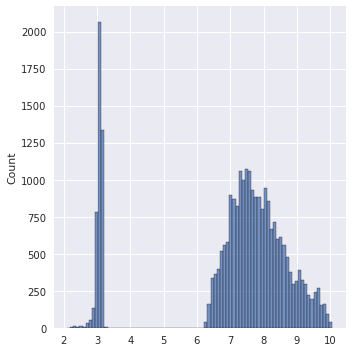

In [168]:
sns.displot(np.log((train["DAYS_BIRTH"] * -1)/ train["work"]))

-33750.0 380250.0


/opt/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


1129

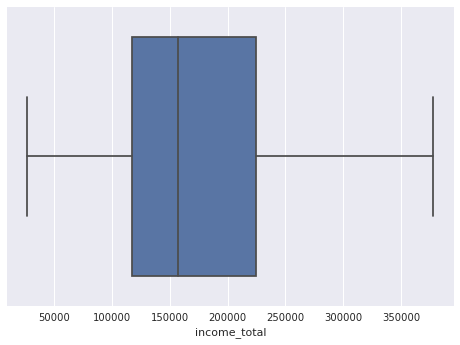

In [189]:
train["income/family"] = train["income_total"] / train["family_size"]
train["fam_child_diff"] = train["family_size"] - train["child_num"] ## 해당의 경우 음수 값이 한개 이므로 제거


# sns.distplot(train["income/family"])
# sns.distplot(np.log1p(train["income/family"]))
data = pd.read_csv('data/train.csv')

# sns.boxplot(data["income_total"])
out_idx = get_outlier_idx(data, "income_total")
data.drop(out_idx, inplace = True, axis = 0)
sns.boxplot(data["income_total"])

len(out_idx)
# sns.displot(np.log(data["income_total"]))

<AxesSubplot:xlabel='family_size', ylabel='count'>

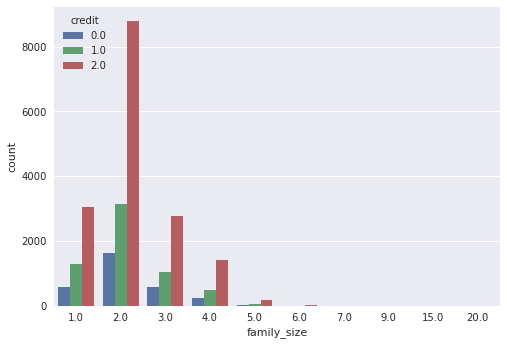

In [195]:
sns.countplot(x = "family_size",hue = "credit", data = data)

In [38]:
# child_num 컬럼의 경우 train 데이터에서 7 이상인 로우 삭제 (test 데이터도 7이하인 데이터만 존재)

test["fam_child_diff"] = test["family_size"] - test["child_num"]
test.fam_child_diff.value_counts()

 2.0    7683
 1.0    2315
-1.0       1
 0.0       1
Name: fam_child_diff, dtype: int64

In [40]:
print(test.family_size.value_counts())
print(train.family_size.value_counts())

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64
2.0     14106
1.0      5109
3.0      4632
4.0      2260
5.0       291
6.0        44
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64


In [501]:
dople_cols = ['gender', 'car', 'reality', 'child_num', 'income_total', 'income_type',
       'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH', 'DAYS_EMPLOYED',
       'FLAG_MOBIL', 'work_phone', 'phone', 'email']

In [ ]:
# child_num 구분
train['child_type'] = train['child_num'].map(classify_child_type)

# family_size 구분
train['family'] = train['family_size'].map(classify_family)

# occyp_type 처리
cond = train['income_type'] == 'Pensioner'
train['occyp_type'] = train['occyp_type'].fillna(cond.map({True:'Unemployed', False: 'Unknown'}))

# days_employed
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].apply(lambda x : 1 if x > 0 else x)

# 파생변수 생성
train['account'] = train.groupby(dople_cols)['index'].transform(len)
# train['credit_max'] = train.groupby(dople_cols)['credit'].transform(max) # credit 변환 최대값
# train['credit_mean'] = train.groupby(dople_cols)['credit'].transform(lambda x : np.mean(x).round()) # credit 변환 평균
train['credit_mode'] = train.groupby(dople_cols)['credit'].transform(lambda x : x if len == 1 else stats.mode(x)[0][0]) # credit 변환 최빈값

train.head()

In [529]:
train['DAYS_EMPLOYED'].value_counts()

 0        4438
-401        57
-1539       47
-200        45
-2087       44
          ... 
-10475       1
-2202        1
-2552        1
-680         1
-4973        1
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

In [528]:
train['occyp_type'].value_counts()

Laborers                 4512
Unemployed               4440
Unknown                  3731
Core staff               2646
Sales staff              2539
Managers                 2167
Drivers                  1575
High skill tech staff    1040
Accountants               902
Medicine staff            864
Cooking staff             457
Security staff            424
Cleaning staff            403
Private service staff     243
Low-skill Laborers        127
Waiters/barmen staff      124
Secretaries                97
Realty agents              63
HR staff                   62
IT staff                   41
Name: occyp_type, dtype: int64

In [521]:
train['income_type'].value_counts()

Working                 13645
Commercial associate     6202
Pensioner                4449
State servant            2154
Student                     7
Name: income_type, dtype: int64

In [496]:
train['child_num'].value_counts(normalize= True).sort_index().to_frame()

,child_num
0,0.693200
1,0.203576
2,0.089277
3,0.011566
4,0.001776
5,0.000378
7,0.000076
14,0.000113
19,0.000038


In [497]:
train['family_size'].value_counts(normalize= True).sort_index().to_frame()

,family_size
1.0,0.193106
2.0,0.533167
3.0,0.175077
4.0,0.085422
5.0,0.010999
6.0,0.001663
7.0,0.000340
9.0,0.000076
15.0,0.000113
20.0,0.000038


In [498]:
train['child_type'].value_counts(normalize= True).sort_index().to_frame()

,child_type
1,0.693200
2,0.292853
3,0.013947


In [499]:
train['family'].value_counts(normalize= True).sort_index().to_frame()

,family
1.0,0.193106
2.0,0.533167
3.0,0.260498
4.0,0.013229


* 타겟 변수인 credit 의 비율을 살펴보았을 때

In [359]:
train['credit'].value_counts(normalize=True)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

In [361]:
train['income_total'].value_counts().sort_values()

191700.0       1
191250.0       1
215100.0       1
151200.0       1
184135.5       1
            ... 
225000.0    2170
112500.0    2178
180000.0    2225
157500.0    2233
135000.0    3164
Name: income_total, Length: 249, dtype: int64

<AxesSubplot:ylabel='income_total'>

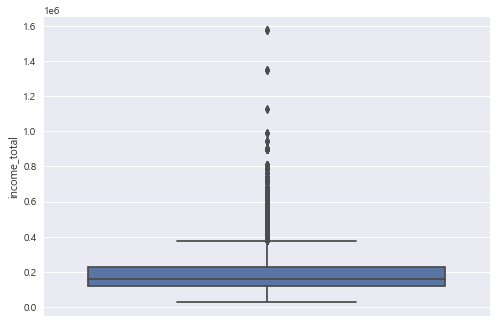

In [364]:
sns.boxplot(data = train, y='income_total')

In [365]:
train['DAYS_BIRTH'].value_counts()

-12676    40
-15519    38
-14667    32
-15140    26
-16768    24
          ..
-18629     1
-12786     1
-13688     1
-14543     1
-19912     1
Name: DAYS_BIRTH, Length: 6621, dtype: int64

* 중복인 문제

 > account 를 만든다고 해서 신용도가 2에서 시작하진 않는다.
 >> 신용도가 2인 사람은 나빠진 것으로 볼 수 있다.

In [40]:
train_raw[train_raw['DAYS_BIRTH'] ==-12676].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
2600,2600,F,N,Y,2,99000.0,Working,Secondary / secondary special,Separated,House / apartment,-12676,-643,1,0,1,0,Laborers,3.0,-5.0,0.0
6972,6972,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-12.0,2.0
24760,24760,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-48.0,2.0
16640,16640,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-49.0,2.0
1871,1871,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-18.0,2.0
1891,1891,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-39.0,2.0
2686,2686,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-56.0,2.0
25285,25285,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-11.0,2.0
3857,3857,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-42.0,2.0
16778,16778,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,-12676,-3455,1,0,0,0,Core staff,2.0,-8.0,2.0


동일인인 것으로 추정되는 데이터 사이에서도 타겟 변수인 credit 값이 모두 동일하진 않음.
최저 등급인 2와 중간 등급인 1이 섞여 있는 경우가 있음

In [89]:
train_raw[train_raw['DAYS_BIRTH'] == multi_days[-11]].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
1860,1860,M,Y,Y,1,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12250,-857,1,0,0,0,Laborers,3.0,-2.0,1.0
19308,19308,M,Y,Y,1,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12250,-857,1,0,0,0,Laborers,3.0,-8.0,2.0
20316,20316,M,Y,Y,1,270000.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-12250,-857,1,0,0,0,Laborers,3.0,-9.0,2.0


In [93]:
train_raw[train_raw['DAYS_BIRTH'] == multi_days[-15]].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
861,861,F,Y,Y,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16582,-1194,1,1,1,0,Cleaning staff,1.0,-6.0,1.0
1130,1130,F,Y,Y,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16582,-1194,1,1,1,0,Cleaning staff,1.0,-19.0,2.0
10327,10327,F,Y,Y,0,270000.0,Working,Secondary / secondary special,Separated,House / apartment,-16582,-1194,1,1,1,0,Cleaning staff,1.0,-21.0,2.0


In [94]:
train_raw[train_raw['DAYS_BIRTH'] == multi_days[-16]].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
9764,9764,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23627,365243,1,0,0,0,NaN,2.0,-42.0,2.0
16340,16340,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23627,365243,1,0,0,0,NaN,2.0,-8.0,2.0
25818,25818,F,N,Y,0,157500.0,Pensioner,Secondary / secondary special,Married,House / apartment,-23627,365243,1,0,0,0,NaN,2.0,-48.0,1.0


In [95]:
train_raw[train_raw['DAYS_BIRTH'] == multi_days[-17]].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
7260,7260,M,N,Y,0,252000.0,Working,Higher education,Married,House / apartment,-16482,-1051,1,1,1,0,Core staff,2.0,-10.0,2.0
5360,5360,F,N,Y,0,382500.0,Working,Higher education,Married,House / apartment,-16482,-3413,1,0,1,1,NaN,2.0,-16.0,2.0
14061,14061,F,N,Y,0,382500.0,Working,Higher education,Married,House / apartment,-16482,-3413,1,0,1,1,NaN,2.0,-47.0,2.0


In [98]:
train_raw[train_raw['DAYS_BIRTH'] == multi_days[5]].sort_values(by='income_total')

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
11618,11618,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-47.0,2.0
910,910,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-50.0,2.0
23096,23096,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-60.0,2.0
17209,17209,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-7.0,2.0
6752,6752,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-25.0,2.0
7220,7220,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-21.0,2.0
25143,25143,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-47.0,2.0
16272,16272,M,Y,Y,0,202500.0,Working,Secondary / secondary special,Married,Municipal apartment,-16896,-354,1,0,1,0,Sales staff,2.0,-31.0,1.0
25120,25120,M,N,Y,0,270000.0,Working,Secondary / secondary special,Married,House / apartment,-16896,-248,1,0,0,0,Laborers,2.0,-2.0,0.0
18221,18221,M,N,Y,0,270000.0,Working,Secondary / secondary special,Married,House / apartment,-16896,-248,1,0,0,0,Laborers,2.0,-2.0,0.0


In [99]:
train_raw.head()

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


<AxesSubplot:xlabel='account', ylabel='count'>

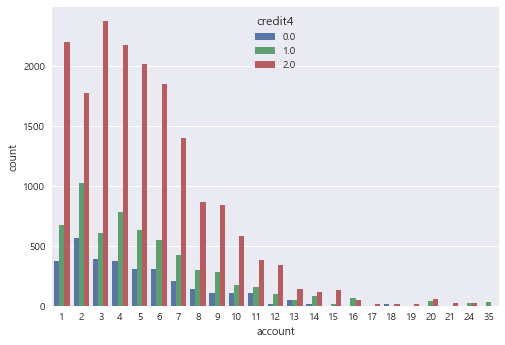

In [568]:
sns.countplot(data = train, x = 'account', hue='credit4')

<AxesSubplot:xlabel='account', ylabel='count'>

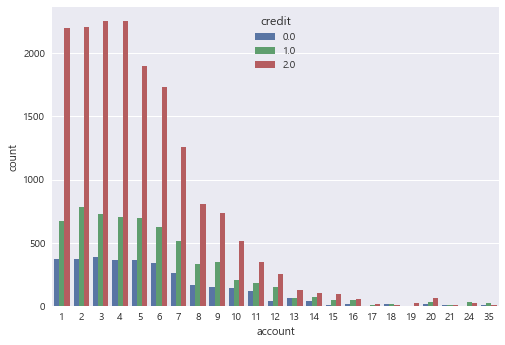

In [566]:
sns.countplot(data = train, x = 'account', hue='credit')

<AxesSubplot:xlabel='personal', ylabel='count'>

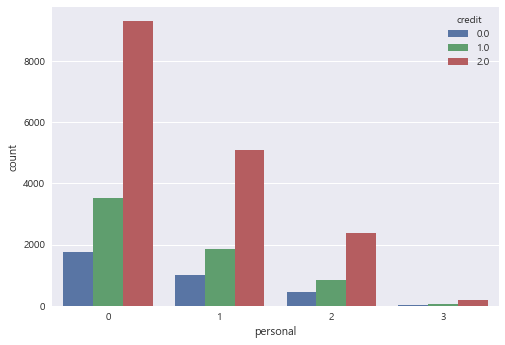

In [110]:
sns.countplot(data = train_raw, x='personal', hue='credit')
# 개인정보를 다 적는 사람은 드물다.. 신용 등급 비율은 비슷한 거 같다.

In [113]:
train_raw[train_raw['personal'] == 0]['credit'].value_counts(normalize=True)

2.0    0.639046
1.0    0.241095
0.0    0.119860
Name: credit, dtype: float64

In [114]:
train_raw[train_raw['personal'] == 1]['credit'].value_counts(normalize=True)

2.0    0.639789
1.0    0.233986
0.0    0.126225
Name: credit, dtype: float64

In [115]:
train_raw[train_raw['personal'] == 2]['credit'].value_counts(normalize=True)

2.0    0.650068
1.0    0.226939
0.0    0.122993
Name: credit, dtype: float64

In [116]:
train_raw[train_raw['personal'] == 3]['credit'].value_counts(normalize=True)

2.0    0.690647
1.0    0.230216
0.0    0.079137
Name: credit, dtype: float64

In [117]:
train['FLAG_MOBIL'].value_counts()

1    26457
Name: FLAG_MOBIL, dtype: int64

<AxesSubplot:xlabel='income_total', ylabel='DAYS_BIRTH'>

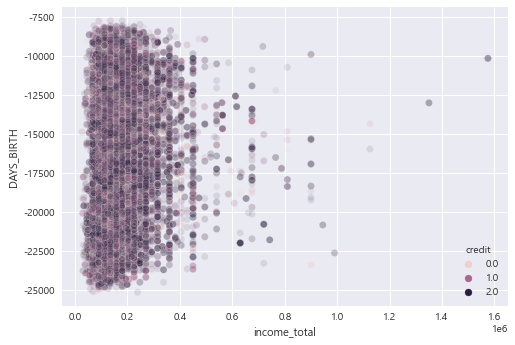

In [119]:
sns.scatterplot(data = train_raw, x='income_total', y='DAYS_BIRTH', hue='credit', alpha = 0.1)

<AxesSubplot:xlabel='DAYS_BIRTH', ylabel='Count'>

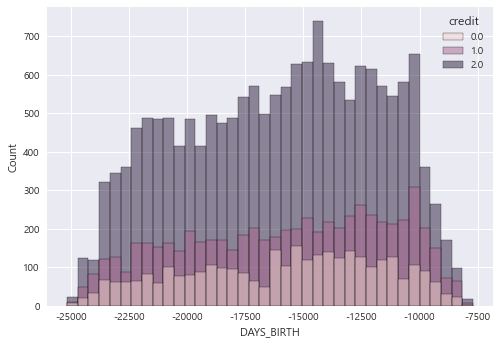

In [369]:
sns.histplot(data = train, x='DAYS_BIRTH',hue='credit')

<AxesSubplot:xlabel='begin_month', ylabel='Count'>

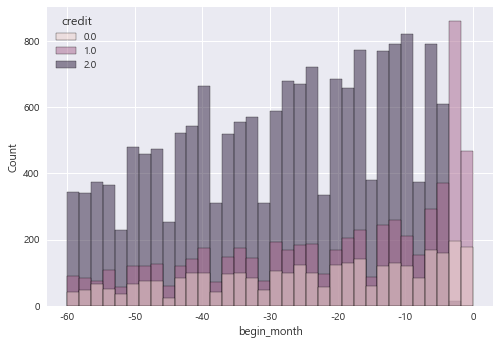

In [370]:
sns.histplot(data = train, x='begin_month', hue='credit')

In [ ]:
rate_df = credit_rate(train, train_columns, 'credit')
rate_df

In [439]:
rate_df2 = credit_rate(train, train_columns, 'credit2')
rate_df2

,gender_F,gender_M,car_N,car_Y,reality_N,reality_Y,child_num_0,child_num_1,child_num_2,child_num_3,...,family_size_2.0,family_size_3.0,family_size_4.0,family_size_1.0,family_size_5.0,family_size_6.0,family_size_7.0,family_size_15.0,family_size_20.0,family_size_9.0
0.0,0.031644,0.035959,0.033577,0.032248,0.035586,0.031856,0.034133,0.033049,0.024979,0.035948,...,0.034099,0.036701,0.023451,0.031317,0.034364,0.022727,NaN,NaN,NaN,NaN
1.0,0.100299,0.100457,0.110420,0.083906,0.086589,0.107011,0.099019,0.101931,0.104149,0.127451,...,0.091805,0.094344,0.105310,0.125856,0.127148,0.022727,0.444444,NaN,NaN,NaN
2.0,0.868057,0.863584,0.856002,0.883846,0.877825,0.861133,0.866848,0.865020,0.870872,0.836601,...,0.874096,0.868955,0.871239,0.842826,0.838488,0.954545,0.555556,1.0,1.0,1.0


<AxesSubplot:>

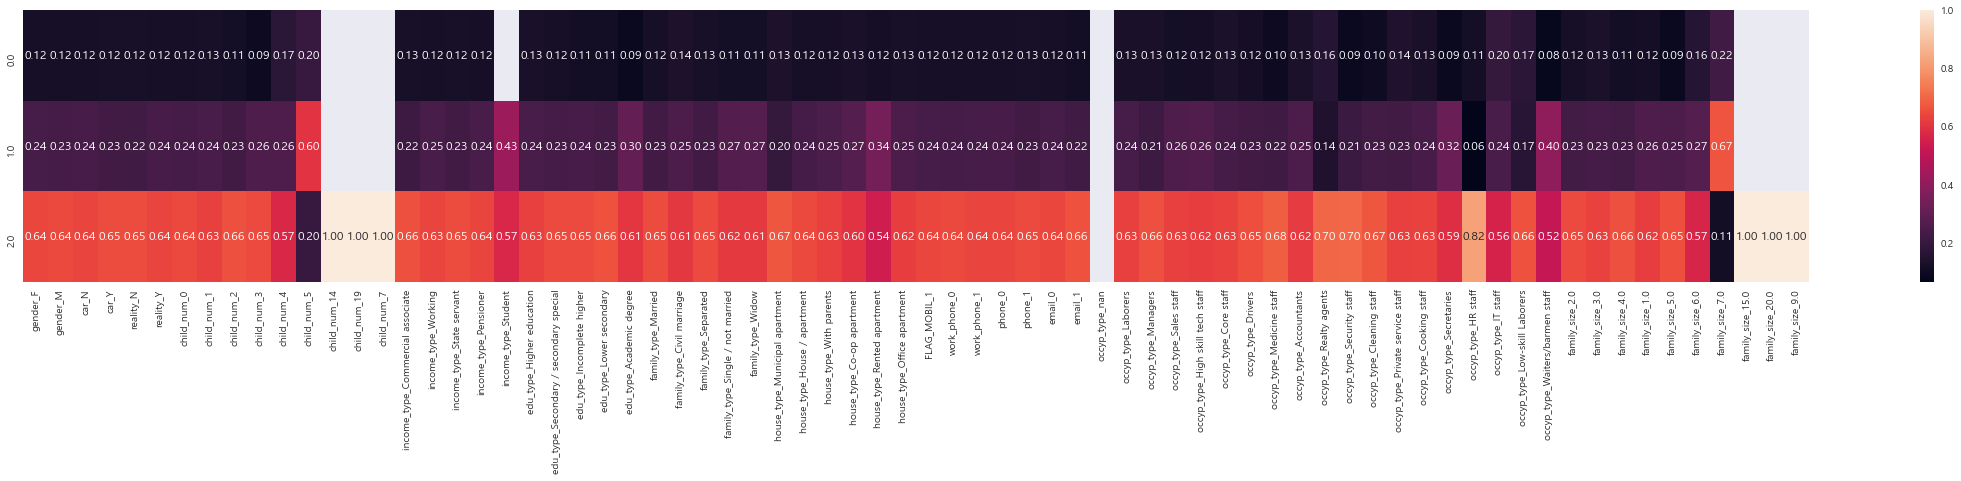

In [423]:
plt.figure(figsize = (40,5))
sns.heatmap(rate_df, annot = True, fmt = '.2f')

<AxesSubplot:>

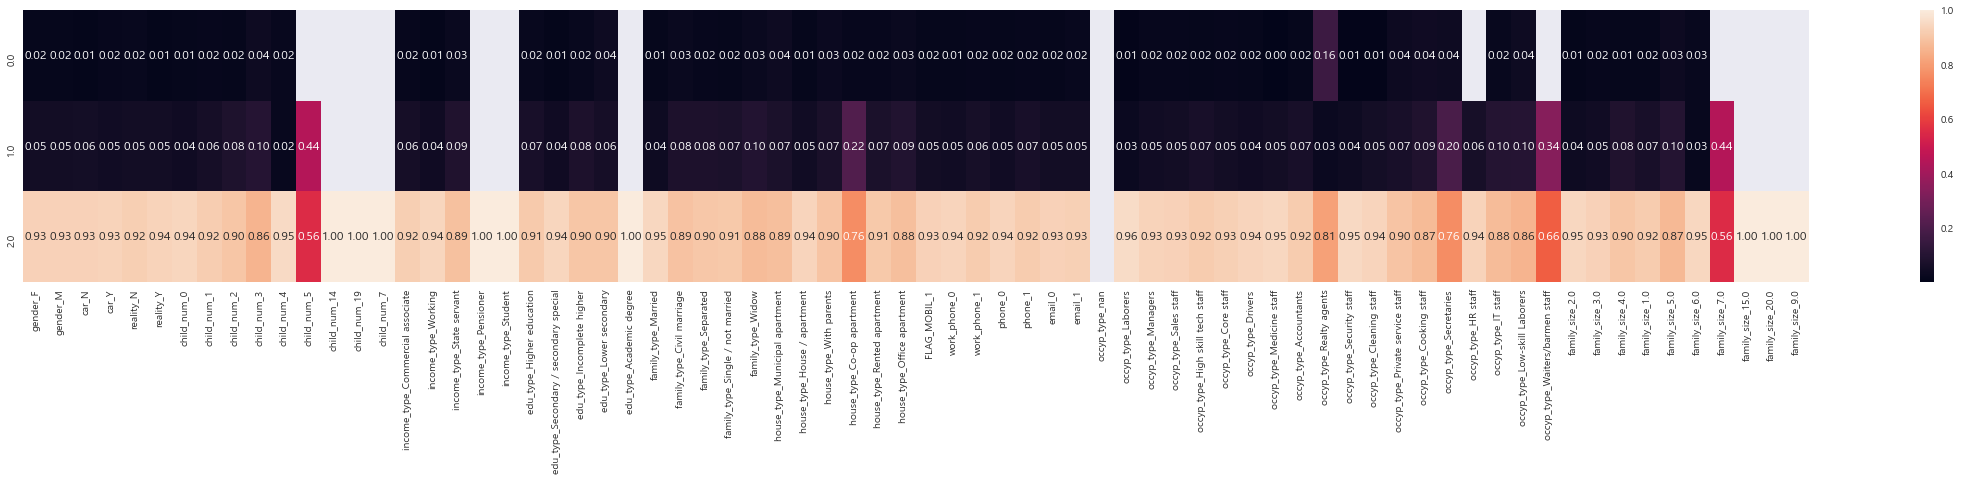

In [422]:
plt.figure(figsize = (40,5))
sns.heatmap(rate_df2, annot = True, fmt = '.2f')

<AxesSubplot:>

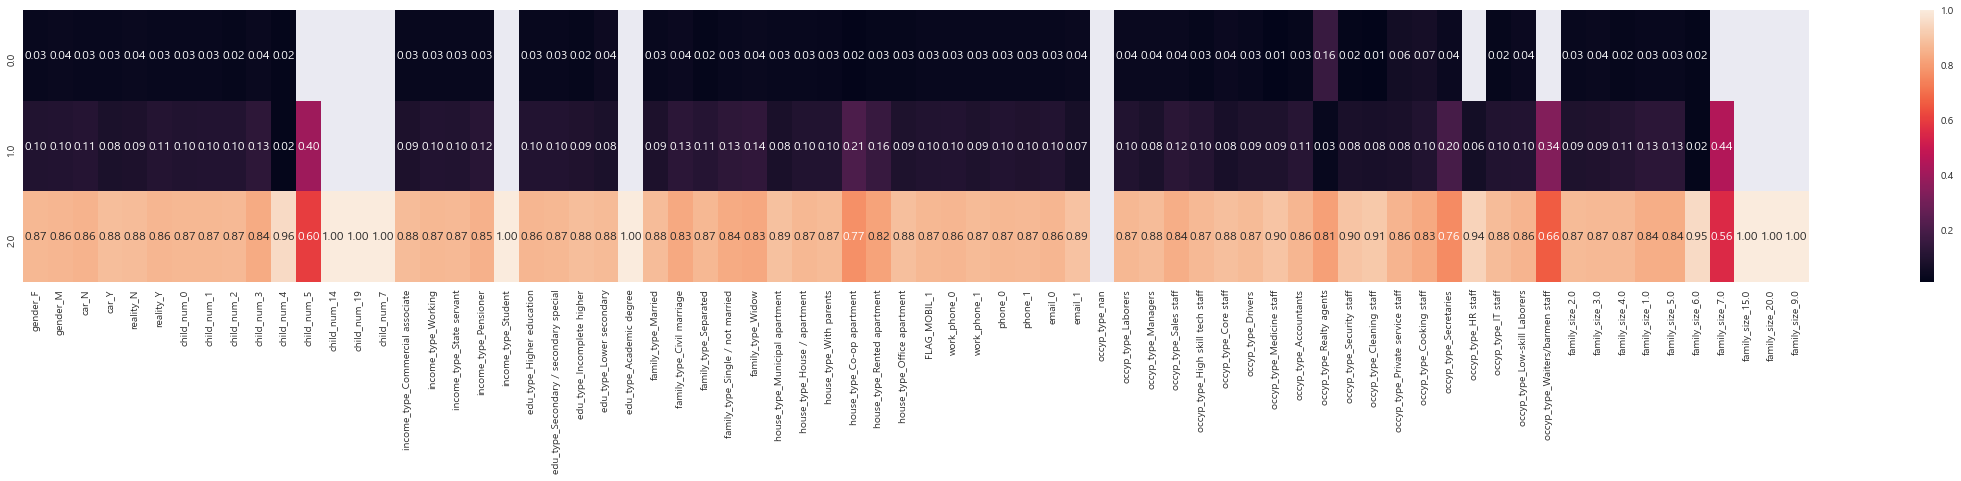

In [440]:
plt.figure(figsize = (40,5))
sns.heatmap(rate_df2, annot = True, fmt = '.2f')

<AxesSubplot:>

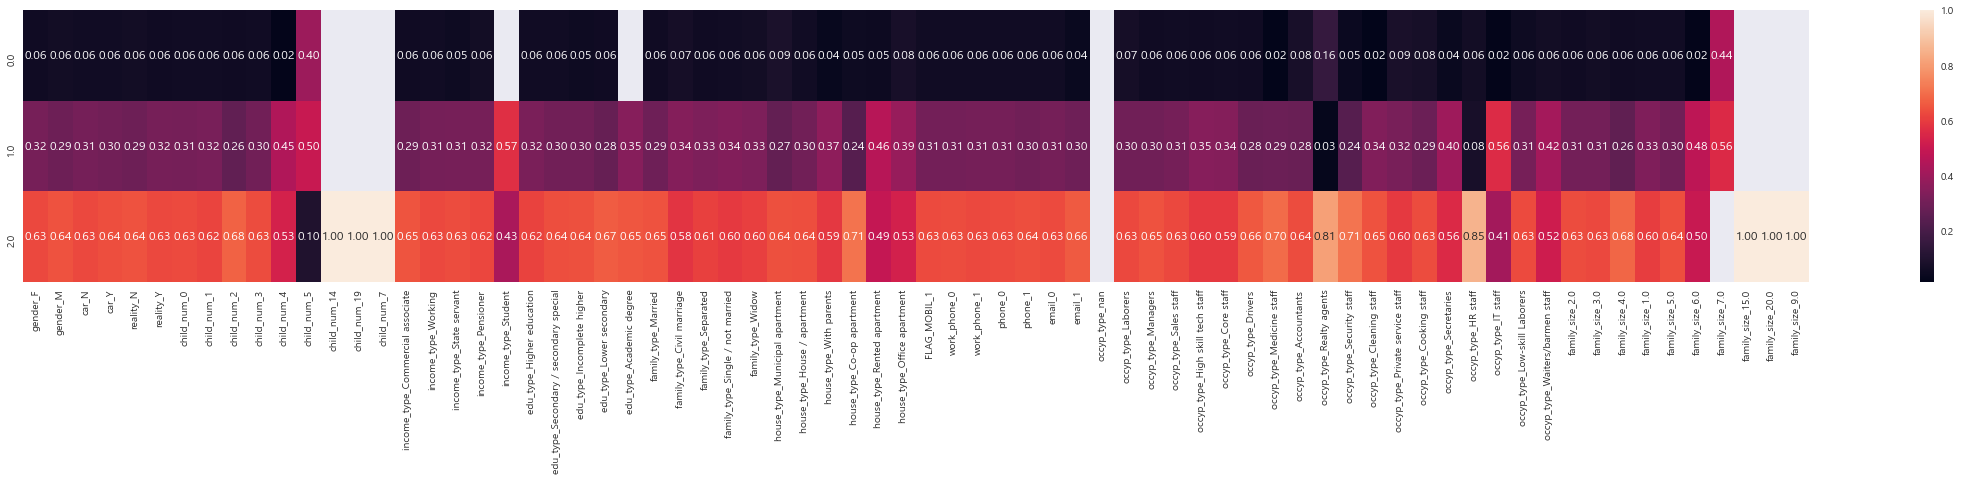

In [447]:
rate_df3 = credit_rate(train, train_columns, 'credit3')
plt.figure(figsize = (40,5))
sns.heatmap(rate_df3, annot = True, fmt = '.2f')

<AxesSubplot:>

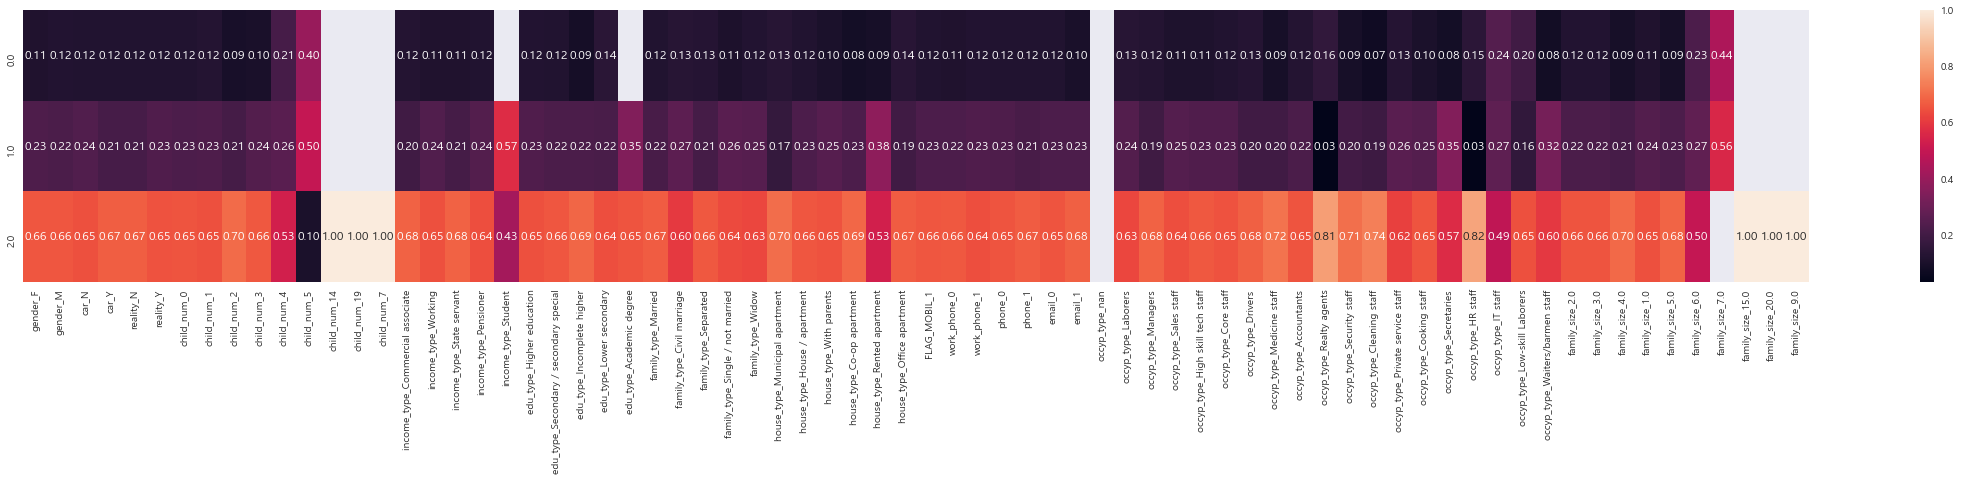

In [469]:
rate_df4 = credit_rate(train, train_columns, 'credit4')
plt.figure(figsize = (40,5))
sns.heatmap(rate_df4, annot = True, fmt = '.2f')

In [530]:
train_columns2 = ['gender', 'car', 'reality', 'child_type', 'income_type', 'edu_type', 'family_type', 'house_type', 
                 'FLAG_MOBIL', 'work_phone', 'phone', 'email','occyp_type', 'family']

rate_df5 = credit_rate(train, train_columns2, 'credit4')

<AxesSubplot:>

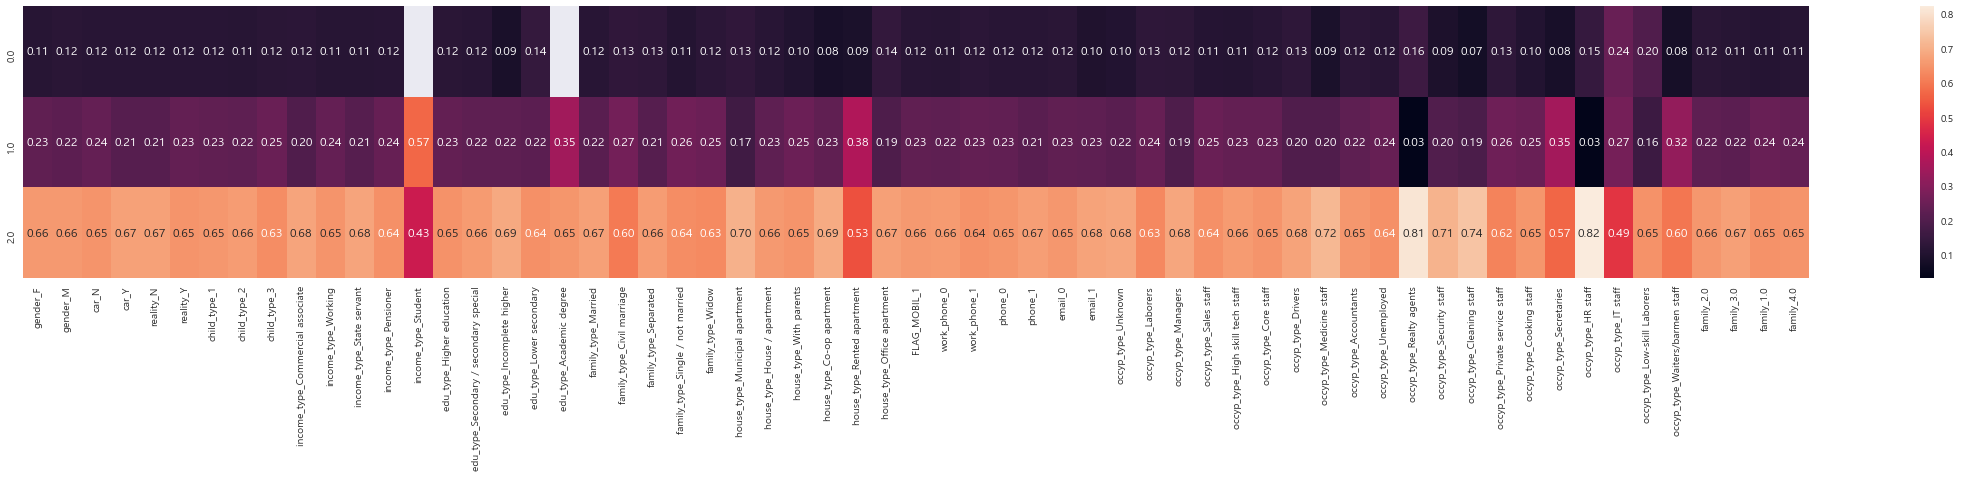

In [531]:
plt.figure(figsize = (40,5))
sns.heatmap(rate_df5, annot = True, fmt = '.2f')

In [486]:
train['income_type'].value_counts(normalize=True)

Working                 0.515743
Commercial associate    0.234418
Pensioner               0.168160
State servant           0.081415
Student                 0.000265
Name: income_type, dtype: float64

In [492]:
train['edu_type'].value_counts(normalize=True)

Secondary / secondary special    0.680160
Higher education                 0.270703
Incomplete higher                0.038553
Lower secondary                  0.009714
Academic degree                  0.000869
Name: edu_type, dtype: float64

<AxesSubplot:xlabel='gender', ylabel='count'>

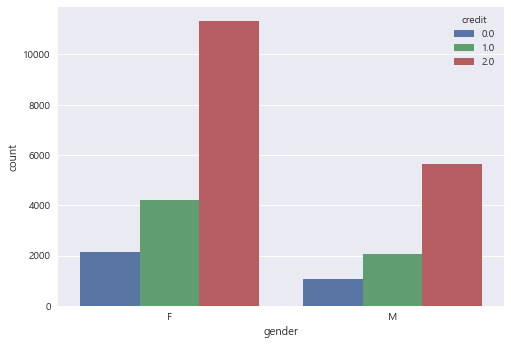

In [123]:
sns.countplot(data = train_raw, x='gender', hue='credit')

In [124]:
train_raw[train_raw['gender'] == 'F']['credit'].value_counts(normalize=True)

2.0    0.640165
1.0    0.238458
0.0    0.121377
Name: credit, dtype: float64

In [125]:
train_raw[train_raw['gender'] == 'M']['credit'].value_counts(normalize=True)

2.0    0.643721
1.0    0.233676
0.0    0.122603
Name: credit, dtype: float64

<AxesSubplot:xlabel='car', ylabel='count'>

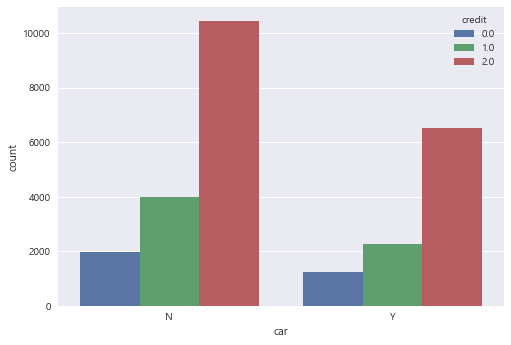

In [126]:
sns.countplot(data = train_raw, x='car', hue='credit')

In [128]:
train_raw[train_raw['car'] == 'Y']['credit'].value_counts(normalize=True)

2.0    0.649945
1.0    0.226635
0.0    0.123420
Name: credit, dtype: float64

In [129]:
train_raw[train_raw['car'] == 'N']['credit'].value_counts(normalize=True)

2.0    0.636076
1.0    0.243144
0.0    0.120780
Name: credit, dtype: float64

<AxesSubplot:xlabel='reality', ylabel='count'>

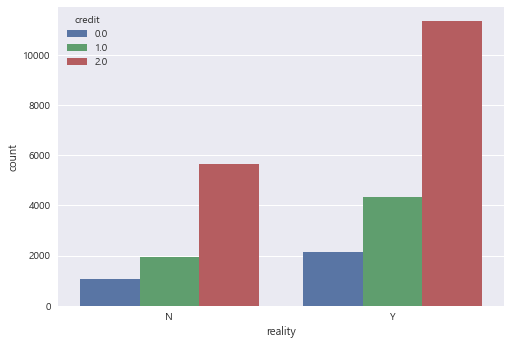

In [130]:
sns.countplot(data = train_raw, x='reality', hue='credit')

In [131]:
train_raw[train_raw['reality'] == 'Y']['credit'].value_counts(normalize=True)

2.0    0.636007
1.0    0.242961
0.0    0.121032
Name: credit, dtype: float64

In [132]:
train_raw[train_raw['reality'] == 'N']['credit'].value_counts(normalize=True)

2.0    0.652370
1.0    0.224296
0.0    0.123334
Name: credit, dtype: float64

In [133]:
train_raw['birth_income'] = train_raw['income_total'] / abs(train_raw['DAYS_BIRTH'])

<AxesSubplot:xlabel='income_type', ylabel='count'>

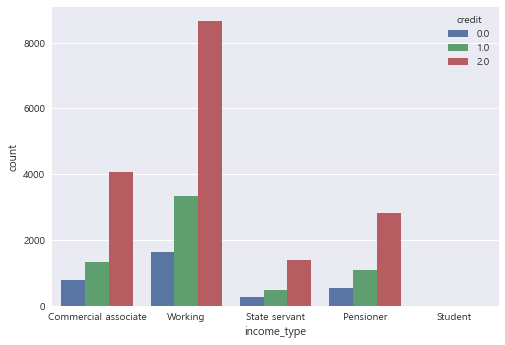

In [136]:
sns.countplot(data = train_raw, x='income_type', hue='credit')

In [138]:
train_raw[train_raw['income_type'] == 'Student']['credit'].value_counts()

2.0    4
1.0    3
Name: credit, dtype: int64

<AxesSubplot:xlabel='child_num', ylabel='count'>

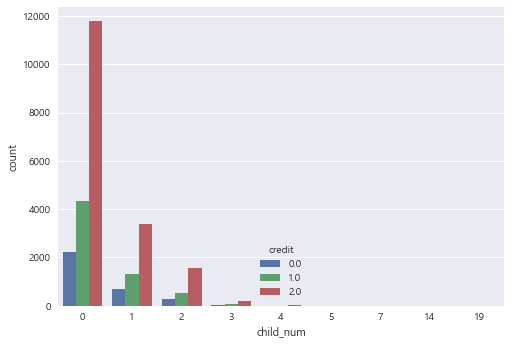

In [139]:
sns.countplot(data = train_raw, x='child_num', hue='credit')

In [141]:
train_raw[train_raw['child_num'] == 0]['credit'].value_counts(normalize=True)

2.0    0.642585
1.0    0.235660
0.0    0.121756
Name: credit, dtype: float64

In [142]:
train_raw[train_raw['child_num'] == 1]['credit'].value_counts(normalize=True)

2.0    0.629595
1.0    0.243780
0.0    0.126625
Name: credit, dtype: float64

In [143]:
train_raw[train_raw['child_num'] == 2]['credit'].value_counts(normalize=True)

2.0    0.660034
1.0    0.226503
0.0    0.113463
Name: credit, dtype: float64

<AxesSubplot:xlabel='edu_type', ylabel='count'>

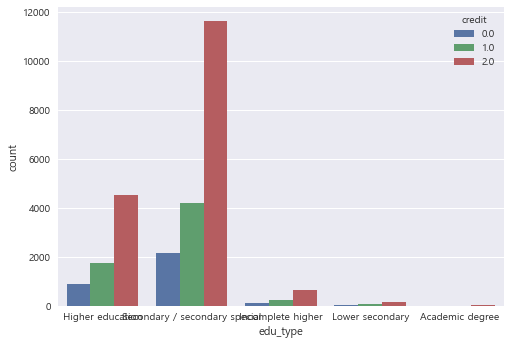

In [144]:
sns.countplot(data = train_raw, x='edu_type', hue='credit')

In [146]:
train_raw[train_raw['edu_type'] == 'Higher education']['credit'].value_counts(normalize=True)

2.0    0.628595
1.0    0.244485
0.0    0.126920
Name: credit, dtype: float64

<AxesSubplot:xlabel='family_size', ylabel='count'>

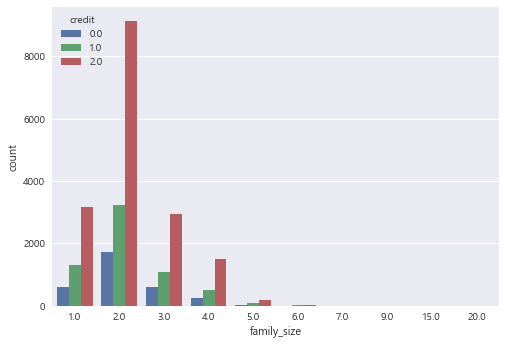

In [147]:
sns.countplot(data = train_raw, x='family_size', hue='credit')

<AxesSubplot:xlabel='family_type', ylabel='count'>

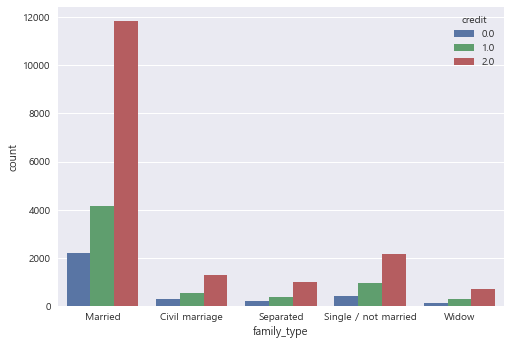

In [148]:
sns.countplot(data = train_raw, x='family_type', hue='credit')

<AxesSubplot:xlabel='house_type', ylabel='count'>

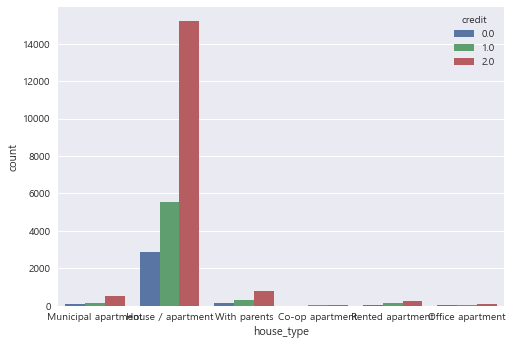

In [149]:
sns.countplot(data = train_raw, x='house_type', hue='credit')

In [155]:
train_raw['DAYS_EMPLOYED'].sort_values()

7561     -15713
6447     -15661
19975    -15661
1297     -15072
4770     -15072
          ...  
12818    365243
12821    365243
12822    365243
22822    365243
19944    365243
Name: DAYS_EMPLOYED, Length: 26457, dtype: int64

In [159]:
train_raw[train_raw['DAYS_EMPLOYED'] > 0]['income_type'].value_counts()

Pensioner    4438
Name: income_type, dtype: int64

In [162]:
train_raw[train_raw['income_type'] == 'Pensioner']['DAYS_EMPLOYED'].value_counts()

 365243    4438
-1325         1
-2208         1
-2745         1
-586          1
-198          1
-443          1
-3680         1
-673          1
-672          1
-620          1
-5521         1
Name: DAYS_EMPLOYED, dtype: int64

In [545]:
train['DAYS_EMPLOYED'].value_counts().sort_index()

-15713       1
-15661       2
-15072       3
-15038      14
-14887       5
          ... 
-70          4
-65          1
-43          1
-17          2
 1        4438
Name: DAYS_EMPLOYED, Length: 3470, dtype: int64

TypeError: 'tuple' object is not callable

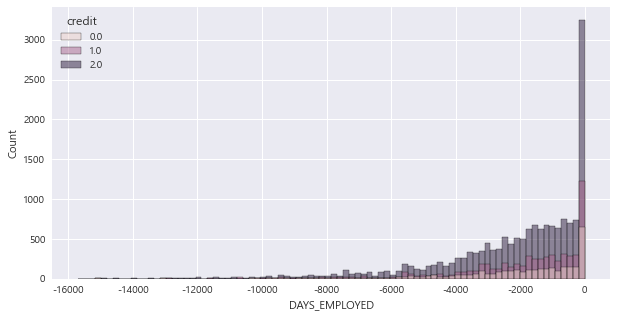

In [563]:
plt.figure(figsize= (10,5))
sns.histplot(data = train, x='DAYS_EMPLOYED', hue='credit')
# plt.ylim(0,1000)
plt.xlim(-16000, -1)
plt.show()

<AxesSubplot:xlabel='work_phone', ylabel='count'>

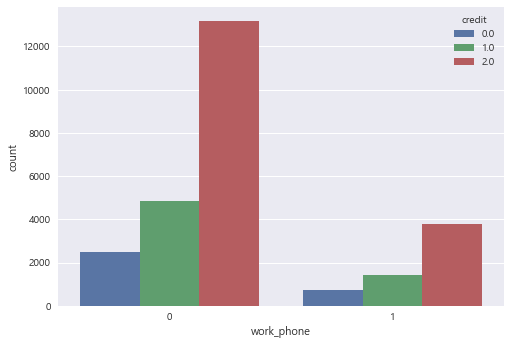

In [165]:
sns.countplot(data = train_raw, x='work_phone', hue='credit')

<AxesSubplot:xlabel='phone', ylabel='count'>

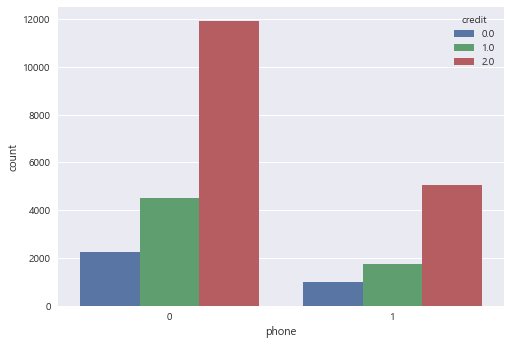

In [166]:
sns.countplot(data = train_raw, x='phone', hue='credit')

<AxesSubplot:xlabel='email', ylabel='count'>

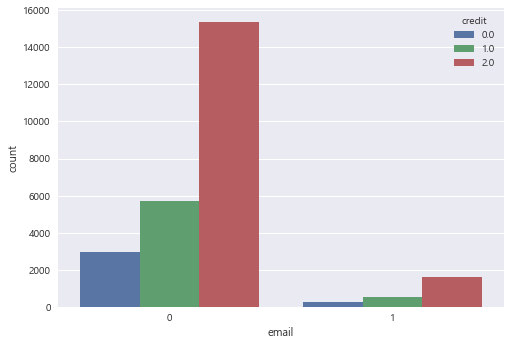

In [167]:
sns.countplot(data = train_raw, x='email', hue='credit')

In [5]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26457 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          26457 non-null  int64  
 1   gender         26457 non-null  object 
 2   car            26457 non-null  object 
 3   reality        26457 non-null  object 
 4   child_num      26457 non-null  int64  
 5   income_total   26457 non-null  float64
 6   income_type    26457 non-null  object 
 7   edu_type       26457 non-null  object 
 8   family_type    26457 non-null  object 
 9   house_type     26457 non-null  object 
 10  DAYS_BIRTH     26457 non-null  int64  
 11  DAYS_EMPLOYED  26457 non-null  int64  
 12  FLAG_MOBIL     26457 non-null  int64  
 13  work_phone     26457 non-null  int64  
 14  phone          26457 non-null  int64  
 15  email          26457 non-null  int64  
 16  occyp_type     18286 non-null  object 
 17  family_size    26457 non-null  float64
 18  begin_

In [6]:
train_raw['edu_type'].value_counts()

Secondary / secondary special    17995
Higher education                  7162
Incomplete higher                 1020
Lower secondary                    257
Academic degree                     23
Name: edu_type, dtype: int64

<AxesSubplot:xlabel='edu_type', ylabel='count'>

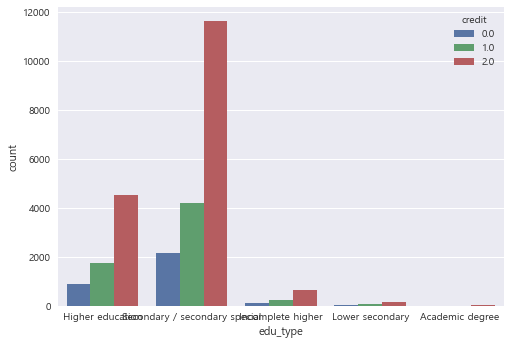

In [7]:
sns.countplot(data= train_raw, x = 'edu_type', hue = 'credit')

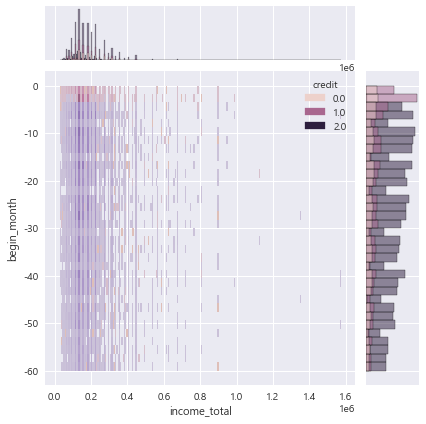

In [26]:
sns.jointplot(data = train_raw, y= 'begin_month', x='income_total', kind='hist', hue= 'credit')

In [27]:
corr = train_raw.corr()

<AxesSubplot:>

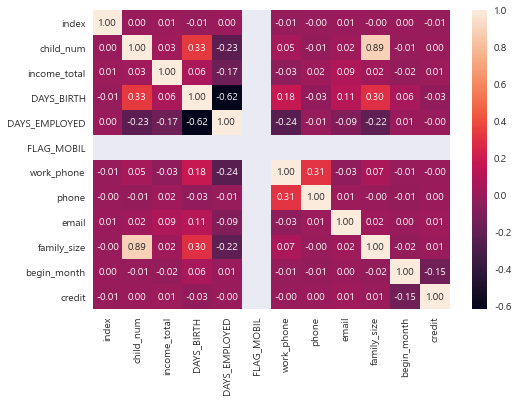

In [29]:
sns.heatmap(corr, annot=True, fmt = '0.2f')

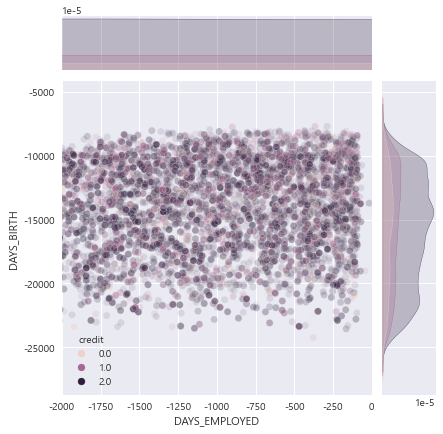

In [44]:
sns.jointplot(data = train_raw, x= 'DAYS_EMPLOYED', y='DAYS_BIRTH', hue= 'credit', xlim = [-2000,0], alpha = 0.1)

In [ ]:
sns.histplot(data = train_raw, x='income_total', binwidth= 1 )

In [289]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [288]:
train_raw.iloc[:,:-1]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,-12079,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,-15291,-2475,1,0,0,0,NaN,2.0,-47.0,2.0
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,-10082,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,-10145,-107,1,0,0,0,Laborers,1.0,-59.0,2.0


In [60]:
train_raw.columns

Index(['index', 'gender', 'car', 'reality', 'child_num', 'income_total',
       'income_type', 'edu_type', 'family_type', 'house_type', 'DAYS_BIRTH',
       'DAYS_EMPLOYED', 'FLAG_MOBIL', 'work_phone', 'phone', 'email',
       'occyp_type', 'family_size', 'begin_month', 'credit'],
      dtype='object')

In [72]:
num_col = ['child_num', 'income_total', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'family_size', 'begin_month']
cate_col = ['gender', 'car', 'reality','income_type', 'edu_type','family_type', 'house_type','work_phone','phone','email', 'occyp_type']

In [64]:
train_raw['occyp_type'] = train_raw['occyp_type'].fillna('Unemployed')

In [70]:
train_raw['DAYS_EMPLOYED'] = train_raw['DAYS_EMPLOYED'].apply(lambda x : 0 if x > 0 else x)

In [75]:
scaler = StandardScaler()

x_num = train_raw[num_col]
scaler.fit(x_num)
x_scaled = scaler.transform(x_num)

x_scaled = pd.DataFrame(x_scaled, index=x_num.index, columns = x_num.columns)

x_cat = pd.get_dummies(train_raw[cate_col], drop_first=True)

X = pd.concat([x_scaled,x_cat], axis = 1)
y = train_raw['credit']

In [92]:
train_x, test_x, train_y, test_y = train_test_split(X, y,test_size= 0.3, random_state=910)

In [77]:
distortions = [] 

k_range = range(1,X.shape[1])

for i in k_range:
  km = KMeans(n_clusters = i)
  km.fit(train_x)
  distortions.append(km.inertia_)

print(distortions)

[176301.63605194635, 147488.72505742076, 132196.11824941344, 122091.84746787288, 114640.31881521356, 108810.54212664712, 104260.22694388169, 100946.21401908642, 98614.82096113941, 96450.64179342099, 94399.28844073761, 92896.09574739524, 91216.35673188018, 89979.93163368267, 88762.62555845463, 87446.95329781857, 86804.73671743585, 85428.25752330749, 84893.48326511482, 83283.16082976744, 83251.21350549508, 81711.07800616501, 81003.25778987187, 80500.87818156075, 80662.79309875531, 79417.01936354178, 78808.73800023102, 78672.16214411407, 77784.6437064711, 77106.23557591607, 76604.4532996832, 76305.97532771512, 75757.68519062153, 75277.21016959223, 74734.8594038587, 74423.9925626426, 74076.79853314688, 73691.51803346272, 73236.46762943098, 73001.87363340466, 72493.83115277567, 72354.1696070009, 72295.09963041346, 71715.45674749478, 71287.45125882028, 71224.81011715742]


<AxesSubplot:>

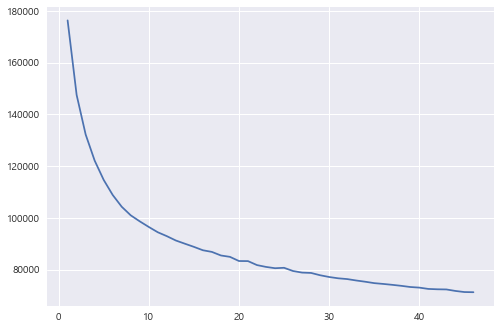

In [290]:
sns.lineplot(x=k_range, y=distortions)

In [82]:
X

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,work_phone,phone,email,gender_M,...,occyp_type_Low-skill Laborers,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Unemployed,occyp_type_Waiters/barmen staff
0,-0.573599,0.149136,0.490075,-1.059227,-0.214735,1.215231,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.764529,0.590848,1.089621,0.277849,0.876135,1.275620,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,-0.573599,2.578550,-0.744719,-0.943198,-0.214735,0.249003,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
3,-0.573599,0.149136,0.207081,0.044947,-0.214735,-0.656836,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
4,-0.573599,-0.292575,0.219220,0.039462,-0.214735,0.007446,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,2.102658,0.369992,0.923252,0.090515,1.967005,1.456788,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26453,0.764529,-0.071719,0.158765,-0.116649,-0.214735,-1.260729,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
26454,-0.573599,1.032559,1.398558,0.077435,-0.214735,0.067835,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26455,-0.573599,-0.160062,1.383563,0.882466,-1.305605,-1.985400,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


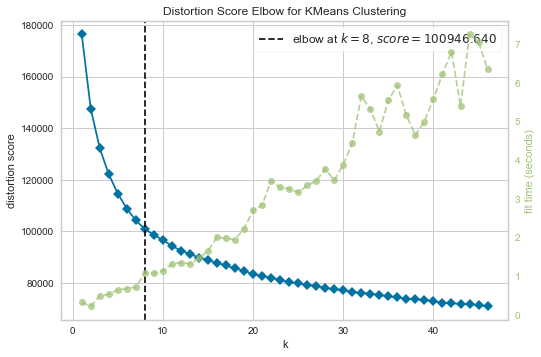

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [89]:
from yellowbrick.cluster import KElbowVisualizer

km = KMeans()
visualizer = KElbowVisualizer(km, k=k_range)
visualizer.fit(train_x)
visualizer.poof() 

In [90]:
km = KMeans(n_clusters = 8).fit(train_x)
train_cluster = km.labels_

In [99]:
train_cluster

array([6, 7, 5, ..., 0, 7, 0])

In [93]:
test_cluster = km.fit_predict(test_x)
print(test_cluster)
print(list(test_y))

[5 1 7 ... 3 0 7]
[2.0, 2.0, 0.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 1.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 0.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 1.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 2.0, 1.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 0.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 0.0, 2.0, 0.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 0.0, 2.0, 2.0, 0.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0, 0.0, 1.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2

In [101]:
import scipy

def find_matching_cluster(cluster_case, actual_labels, cluster_labels):
    matched_cluster={}
    actual_case = list(set(actual_labels))
    for i in cluster_case:
      idx = cluster_labels == i
      new_label=scipy.stats.mode(actual_labels[idx])[0][0]  # 동일한 위치의 label에서 가장 빈번한 cluster명을 찾아줍니다. (=mode)
#       actual_case.remove(new_label)
      # 매칭되는 실제 label명을 dict형태로 저장.
      matched_cluster[i]=new_label
      print(f"훈련된 label명: {i} >> 가장 빈번한 실제 label명: {new_label}")
    return matched_cluster

In [95]:
km_train_case = list(set(train_cluster))
print(km_train_case)

[0, 1, 2, 3, 4, 5, 6, 7]


In [103]:
train_perm_dict = find_matching_cluster(km_train_case, train_y, train_cluster)
print(list(train_y)[:10])
print(train_cluster[:10])
print(train_perm_dict)

훈련된 label명: 0 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 1 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 2 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 3 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 4 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 5 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 6 >> 가장 빈번한 실제 label명: 2.0
훈련된 label명: 7 >> 가장 빈번한 실제 label명: 2.0
[2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 2.0, 1.0, 2.0]
[6 7 5 2 3 0 3 7 7 3]
{0: 2.0, 1: 2.0, 2: 2.0, 3: 2.0, 4: 2.0, 5: 2.0, 6: 2.0, 7: 2.0}


In [291]:
temp = pd.concat([pd.DataFrame(train_y), pd.DataFrame(train_cluster, index = train_y.index)], join='inner' ,axis = 1)

In [292]:
temp.columns = ['credit','cluster']

In [293]:
temp

,credit,cluster
6807,2.0,6
22950,2.0,7
2251,2.0,5
15979,2.0,2
15143,2.0,3
...,...,...
23490,1.0,5
4907,2.0,3
9586,2.0,0
9263,2.0,7


<AxesSubplot:xlabel='cluster', ylabel='count'>

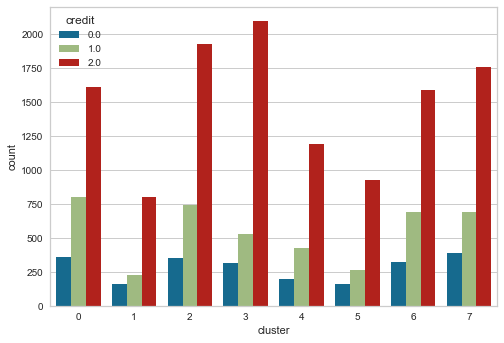

In [123]:
sns.countplot(data = temp , x='cluster', hue='credit')

m

In [156]:
temp = pd.DataFrame(train_raw['DAYS_BIRTH'].value_counts())
multi_birth = temp[temp['DAYS_BIRTH'] > 2].index

In [136]:
multi_birth.shape[0]

3683

In [154]:
multi_birth.index

Int64Index([-12676, -15519, -14667, -15140, -16768, -16896, -15653, -13788,
             -9952, -14136,
            ...
            -19478,  -9481, -16244, -21381, -11831, -14221, -19750, -15775,
            -22651, -15583],
           dtype='int64', length=3683)

In [165]:
multi_employed = train_raw[train_raw['DAYS_BIRTH'] == -12676]['DAYS_EMPLOYED'].value_counts().index

In [167]:
multi_employed

Int64Index([-1350, -3455, -917, -643], dtype='int64')

In [174]:
multi_income = train_raw[(train_raw['DAYS_BIRTH'] == -12676)&(train_raw['DAYS_EMPLOYED'] == -1350)]['income_total'].value_counts().index

In [172]:
multi_income

Float64Index([157500.0], dtype='float64')

In [182]:
train_raw['cards'] = 0

In [196]:
train_raw[train_raw['DAYS_BIRTH'] == -12676]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,cards
762,762,F,N,Y,1,157500.0,State servant,Secondary / secondary special,Single / not married,House / apartment,...,-1350,1,0,0,0,Waiters/barmen staff,2.0,-16.0,1.0,24.0
829,829,F,N,Y,1,157500.0,State servant,Secondary / secondary special,Single / not married,House / apartment,...,-1350,1,0,0,0,Waiters/barmen staff,2.0,-17.0,1.0,24.0
1623,1623,F,N,Y,1,157500.0,State servant,Secondary / secondary special,Single / not married,House / apartment,...,-1350,1,0,0,0,Waiters/barmen staff,2.0,-23.0,1.0,24.0
1871,1871,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,...,-3455,1,0,0,0,Core staff,2.0,-18.0,2.0,NaN
1891,1891,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,...,-3455,1,0,0,0,Core staff,2.0,-39.0,2.0,NaN
2600,2600,F,N,Y,2,99000.0,Working,Secondary / secondary special,Separated,House / apartment,...,-643,1,0,1,0,Laborers,3.0,-5.0,0.0,NaN
2686,2686,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,...,-3455,1,0,0,0,Core staff,2.0,-56.0,2.0,NaN
2912,2912,F,N,Y,1,157500.0,State servant,Secondary / secondary special,Single / not married,House / apartment,...,-1350,1,0,0,0,Waiters/barmen staff,2.0,-23.0,1.0,24.0
3857,3857,F,N,Y,0,130500.0,State servant,Secondary / secondary special,Married,House / apartment,...,-3455,1,0,0,0,Core staff,2.0,-42.0,2.0,NaN
4521,4521,M,Y,Y,1,270000.0,Working,Secondary / secondary special,Married,House / apartment,...,-917,1,0,1,0,Drivers,3.0,-37.0,1.0,NaN


In [311]:
train_raw[train_raw['card2'] == 35]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,card2,cluster
98,130,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-1.0,0.0,35,6
459,647,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-15.0,1.0,35,6
505,717,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-36.0,0.0,35,3
626,888,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-3.0,0.0,35,6
2082,2927,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-12.0,0.0,35,6
2649,3739,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-18.0,1.0,35,6
6327,9074,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-7.0,1.0,35,6
7241,10368,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-31.0,0.0,35,3
7669,10985,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-12.0,1.0,35,6
7674,10991,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,...,1,0,0,0,Laborers,1.0,-13.0,1.0,35,6


<AxesSubplot:xlabel='begin_month', ylabel='credit'>

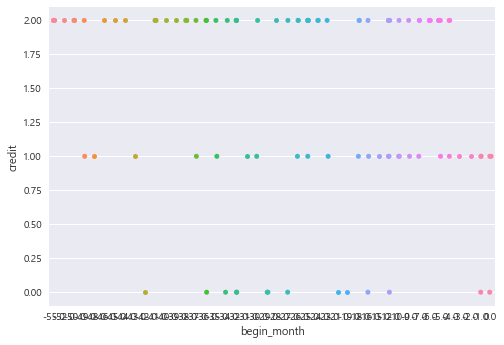

In [287]:
sns.stripplot(data = train_raw[train_raw['card2'] == 20], x='begin_month', y='credit')

In [249]:
test['card'] = test.groupby(dople_col2)['index'].transform(len)

In [250]:
test['card'].value_counts().sort_index()

1     3098
2     2766
3     1791
4     1096
5      610
6      288
7      196
8       64
9       54
10      10
11      11
16      16
Name: card, dtype: int64

In [251]:
test[test['card'] == 16]

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,card
573,27030,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-16.0,16
952,27409,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-6.0,16
1099,27556,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-22.0,16
2085,28542,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-5.0,16
2302,28759,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-32.0,16
2870,29327,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-19.0,16
4240,30697,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-26.0,16
4615,31072,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-9.0,16
4945,31402,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,0.0,16
5139,31596,F,N,Y,0,297000.0,Commercial associate,Secondary / secondary special,Single / not married,Rented apartment,-15519,-3234,1,0,0,0,Laborers,1.0,-18.0,16


In [296]:
train_x['cluster'] = train_cluster.copy()

In [298]:
train_x

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,family_size,begin_month,work_phone,phone,email,gender_M,...,occyp_type_Managers,occyp_type_Medicine staff,occyp_type_Private service staff,occyp_type_Realty agents,occyp_type_Sales staff,occyp_type_Secretaries,occyp_type_Security staff,occyp_type_Unemployed,occyp_type_Waiters/barmen staff,cluster
6807,-0.573599,-0.601773,-0.595011,0.039884,-1.305605,-0.173722,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
22950,0.764529,-0.071719,0.446519,0.168149,0.876135,-0.958782,0,0,0,1,...,1,0,0,0,0,0,0,0,0,7
2251,-0.573599,-1.529368,-0.429357,-2.335547,-0.214735,0.369781,1,1,0,0,...,0,0,0,0,0,0,0,0,0,5
15979,-0.573599,-0.734287,-1.614883,0.927612,-1.305605,-0.234111,0,0,0,0,...,0,0,0,0,0,0,0,1,0,2
15143,-0.573599,-0.513431,-1.338316,-1.379046,-1.305605,-2.045789,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23490,-0.573599,0.281650,-0.759714,-2.200953,-0.214735,1.517177,0,0,1,1,...,1,0,0,0,0,0,0,0,0,5
4907,-0.573599,0.811704,-0.576923,-1.373561,-0.214735,-1.502286,0,0,0,0,...,1,0,0,0,0,0,0,0,0,3
9586,0.764529,-0.071719,0.865178,-0.295123,-0.214735,0.973674,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
9263,0.764529,0.811704,0.011675,0.060559,0.876135,-0.294501,0,0,1,1,...,1,0,0,0,0,0,0,0,0,7


In [306]:
cluster_df = pd.DataFrame(train_x['cluster']).reset_index()

In [307]:
cluster_df

,index,cluster
0,6807,6
1,22950,7
2,2251,5
3,15979,2
4,15143,3
...,...,...
18514,23490,5
18515,4907,3
18516,9586,0
18517,9263,7


In [310]:
train_raw = train_raw.merge(cluster_df, how='inner', on='index' )

In [309]:
train_raw

,index,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,...,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit,card2
0,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,...,-4709,1,0,0,0,NaN,2.0,-6.0,1.0,5
1,1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,...,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0,9
2,2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,...,-4434,1,0,1,0,Managers,2.0,-22.0,2.0,6
3,3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,...,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0,2
4,4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,...,-2105,1,0,0,0,Managers,2.0,-26.0,2.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26452,26452,F,N,N,2,225000.0,State servant,Secondary / secondary special,Married,House / apartment,...,-1984,1,0,0,0,Core staff,4.0,-2.0,1.0,5
26453,26453,F,N,Y,1,180000.0,Working,Higher education,Separated,House / apartment,...,-2475,1,0,0,0,NaN,2.0,-47.0,2.0,1
26454,26454,F,Y,N,0,292500.0,Working,Secondary / secondary special,Civil marriage,With parents,...,-2015,1,0,0,0,Core staff,2.0,-25.0,2.0,1
26455,26455,M,N,Y,0,171000.0,Working,Incomplete higher,Single / not married,House / apartment,...,-107,1,0,0,0,Laborers,1.0,-59.0,2.0,1


In [312]:
train_raw['occyp_type'].value_counts()

Laborers                 3185
Core staff               1856
Sales staff              1765
Managers                 1508
Drivers                  1094
High skill tech staff     733
Accountants               659
Medicine staff            618
Cooking staff             313
Security staff            298
Cleaning staff            278
Private service staff     165
Low-skill Laborers        100
Waiters/barmen staff       87
Secretaries                62
Realty agents              43
HR staff                   41
IT staff                   28
Name: occyp_type, dtype: int64

In [314]:
train_raw[train_raw['occyp_type'].isna()]['income_type'].value_counts()

Pensioner               3087
Working                 1601
Commercial associate     717
State servant            281
Name: income_type, dtype: int64

In [315]:
train_raw[train_raw['occyp_type'].isna()]['DAYS_EMPLOYED'].value_counts()

 365243    3086
-3079        16
-5639        14
-137         14
-302         14
           ... 
-4463         1
-1312         1
-2908         1
-5088         1
-473          1
Name: DAYS_EMPLOYED, Length: 864, dtype: int64

In [323]:
train_raw['DAYS_EMPLOYED'].value_counts().sort_index()

-15713        1
-15661        1
-15072        3
-15038       10
-14887        4
           ... 
-70           3
-65           1
-43           1
-17           1
 365243    3086
Name: DAYS_EMPLOYED, Length: 3227, dtype: int64

In [317]:
train_raw[train_raw['income_type'] =='State servant']['occyp_type'].value_counts()

Core staff               453
Medicine staff           192
Managers                 151
Laborers                 105
High skill tech staff     99
Drivers                   61
Accountants               55
Cooking staff             27
Waiters/barmen staff      20
Secretaries               14
Private service staff     11
Cleaning staff            11
Security staff             9
Sales staff                6
IT staff                   4
Low-skill Laborers         2
HR staff                   2
Name: occyp_type, dtype: int64

In [325]:
train_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18519 entries, 0 to 18518
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          18519 non-null  int64  
 1   gender         18519 non-null  object 
 2   car            18519 non-null  object 
 3   reality        18519 non-null  object 
 4   child_num      18519 non-null  int64  
 5   income_total   18519 non-null  float64
 6   income_type    18519 non-null  object 
 7   edu_type       18519 non-null  object 
 8   family_type    18519 non-null  object 
 9   house_type     18519 non-null  object 
 10  DAYS_BIRTH     18519 non-null  int64  
 11  DAYS_EMPLOYED  18519 non-null  int64  
 12  FLAG_MOBIL     18519 non-null  int64  
 13  work_phone     18519 non-null  int64  
 14  phone          18519 non-null  int64  
 15  email          18519 non-null  int64  
 16  occyp_type     12833 non-null  object 
 17  family_size    18519 non-null  float64
 18  begin_

In [335]:
cate = train_raw[train_raw['occyp_type'].notna()][['gender','car','reality','income_type','edu_type','family_type','house_type','occyp_type']]

In [339]:
cate['occyp_type'].value_counts()

12833

In [340]:
from sklearn import preprocessing

label = preprocessing.LabelEncoder()
data_encoded = pd.DataFrame() 

for i in cate.columns :
  data_encoded[i]=label.fit_transform(cate[i])

In [341]:
data_encoded.head()

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
0,0,0,1,0,4,0,1,8
1,1,1,1,4,1,1,1,10
2,0,0,1,4,4,1,1,6
3,0,0,0,4,4,2,1,3
4,1,0,1,0,4,1,1,4


In [342]:
from scipy.stats import chi2_contingency

def cramers_V(var1,var2) :
  crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
  stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
  obs = np.sum(crosstab) # Number of observations
  mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
  return (stat/(obs*mini))

In [343]:
rows= []

for var1 in data_encoded:
  col = []
  for var2 in data_encoded :
    cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)

df

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
gender,1.00,0.11,0.00,0.01,0.00,0.02,0.00,0.32
car,0.11,1.00,0.00,0.00,0.01,0.02,0.00,0.07
reality,0.00,0.00,1.00,0.00,0.00,0.00,0.04,0.00
income_type,0.01,0.00,0.00,1.00,0.01,0.00,0.00,0.03
edu_type,0.00,0.01,0.00,0.01,1.00,0.00,0.00,0.05
family_type,0.02,0.02,0.00,0.00,0.00,1.00,0.00,0.01
house_type,0.00,0.00,0.04,0.00,0.00,0.00,1.00,0.01
occyp_type,0.32,0.07,0.00,0.03,0.05,0.01,0.01,1.00


C:\Users\choi1\AppData\Local\Temp/ipykernel_14588/3127857870.py:1: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(df, dtype=np.bool)


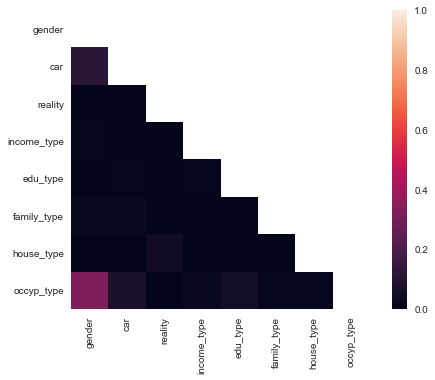

In [344]:
mask = np.zeros_like(df, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

with sns.axes_style("white"):
  ax = sns.heatmap(df, mask=mask,vmin=0., vmax=1, square=True)
plt.show()

In [345]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8 entries, gender to occyp_type
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   gender       8 non-null      float64
 1   car          8 non-null      float64
 2   reality      8 non-null      float64
 3   income_type  8 non-null      float64
 4   edu_type     8 non-null      float64
 5   family_type  8 non-null      float64
 6   house_type   8 non-null      float64
 7   occyp_type   8 non-null      float64
dtypes: float64(8)
memory usage: 876.0+ bytes


In [349]:
df.head()

,gender,car,reality,income_type,edu_type,family_type,house_type,occyp_type
gender,1.00,0.11,0.0,0.01,0.00,0.02,0.00,0.32
car,0.11,1.00,0.0,0.00,0.01,0.02,0.00,0.07
reality,0.00,0.00,1.0,0.00,0.00,0.00,0.04,0.00
income_type,0.01,0.00,0.0,1.00,0.01,0.00,0.00,0.03
edu_type,0.00,0.01,0.0,0.01,1.00,0.00,0.00,0.05
